# Astroplanning

### Importing Packages

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astroplan.plots import plot_airmass, plot_altitude, plot_parallactic, plot_sky
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive
from astroplan import is_observable, is_always_observable, months_observable
from astroplan import (FixedTarget, Observer, EclipsingSystem, AltitudeConstraint, AtNightConstraint, AirmassConstraint, MoonSeparationConstraint)
from astroplan.utils import time_grid_from_range

from astroplan.scheduling import (Transitioner, SequentialScheduler, PriorityScheduler, Schedule)
#from astroplan.scheduling import SequentialScheduler
#from astroplan.scheduling import PriorityScheduler
#from astroplan.scheduling import Schedule
from astroplan import ObservingBlock
from astroplan.constraints import TimeConstraint

# to install astroplan: Open Anaconda Powershell Prompt, type pip install astroplan in terminal.

%matplotlib inline

### Rise and Set Times

In [12]:
villanova = Observer(longitude=-75.3426*u.deg, latitude=40.034901*u.deg, elevation=140*u.m, name="Villanova", timezone="US/Eastern")

timeKep = Time('2023-11-10 22:00:00') # two different times because TOI objects from previous day set as Kepler rises, 
timeTOI = Time('2023-11-11 02:30:00') #     code below too dumb to account for that and I don't feel like fixing it. This works.

Kepler_828b = FixedTarget.from_name('Kepler-828 b')
TOI_1634b = FixedTarget.from_name('TOI-1634 b')
TOI_532b = FixedTarget.from_name('TOI-532 b')


Kepler828_rise = villanova.target_rise_time(timeKep, Kepler_828b) + 5*u.minute
Kepler828_set = villanova.target_set_time(timeKep, Kepler_828b) - 5*u.minute

TOI1634_rise = villanova.target_rise_time(timeTOI, TOI_1634b) + 5*u.minute
TOI1634_set = villanova.target_set_time(timeTOI, TOI_1634b) - 5*u.minute

TOI532_rise = villanova.target_rise_time(timeTOI, TOI_532b) + 5*u.minute
TOI532_set = villanova.target_set_time(timeTOI, TOI_532b) - 5*u.minute

all_up_start = np.max([Kepler828_rise, TOI1634_rise, TOI532_rise])
#print("All up: ", all_up_start.iso)
all_up_end = np.min([Kepler828_set, TOI1634_set, TOI532_set])
#print("All down: ", all_up_end.iso)

sunset_tonight = villanova.sun_set_time(timeKep, which='nearest')
sunsettime = sunset_tonight.iso 

sunrise_tonight = villanova.sun_rise_time(timeKep, which='nearest')
sunrisetime = sunrise_tonight.iso 

start = np.max([sunset_tonight, all_up_start])
#print("Start observations at: ", start.iso) 

end = np.min([sunrise_tonight, all_up_end])
#print("End observations at: ", end.iso) 


if villanova.is_night(timeKep) is True:
    print("It is night.")
    print("Kepler-828 b rises at ", Kepler828_rise.iso, "UTC and sets at ", Kepler828_set.iso, "UTC")
    print("TOI-1634 b rises at ", TOI1634_rise.iso, "UTC and sets at ", TOI1634_set.iso, "UTC")
    print("TOI-532 b rises at ", TOI532_rise.iso, "UTC and sets at ", TOI532_set.iso, "UTC")
    
else:
    print("It is not night. Do not observe.")



It is night.
Kepler-828 b rises at  2023-11-10 11:35:40.413 UTC and sets at  2023-11-11 06:05:37.549 UTC
TOI-1634 b rises at  2023-11-10 20:56:04.887 UTC and sets at  2023-11-11 14:00:04.194 UTC
TOI-532 b rises at  2023-11-11 00:48:44.438 UTC and sets at  2023-11-11 13:55:50.910 UTC


### Altitude Plot

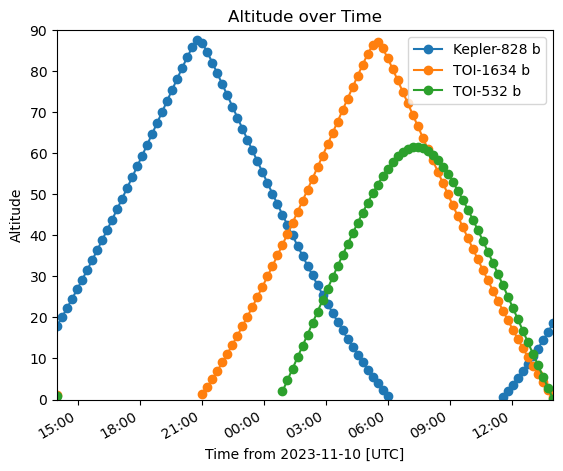

In [13]:
mid_time = Time('2023-11-11 02:00:00') # middle of observation run

plot_altitude(Kepler_828b, villanova, mid_time) 
plot_altitude(TOI_1634b, villanova, mid_time) 
plot_altitude(TOI_532b, villanova, mid_time)
plt.title("Altitude over Time")
plt.legend()

### Airmass Plot

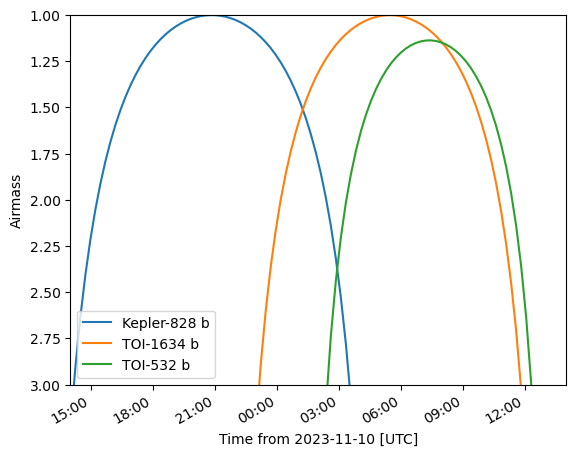

In [14]:

plot_airmass(Kepler_828b, villanova, mid_time) 
plot_airmass(TOI_1634b, villanova, mid_time) 
plot_airmass(TOI_532b, villanova, mid_time)
plt.legend()


#print("Airmass of Kepler-828 b: ", villanova.altaz(timeKep, Kepler_828b).secz)
#print("Airmass of TOI-1634 b: ", villanova.altaz(timeKep, TOI_1634b).secz)
#print("Airmass of TOI-532 b: ", villanova.altaz(timeKep, TOI_532b).secz)


### Parallactic Angle Plot

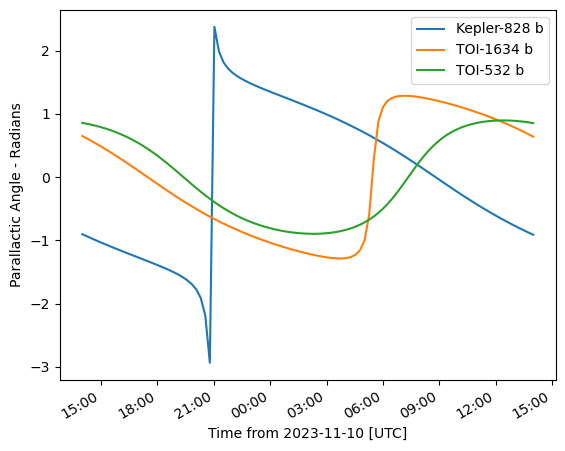

In [15]:

plot_parallactic(Kepler_828b, villanova, mid_time) 
plot_parallactic(TOI_1634b, villanova, mid_time) 
plot_parallactic(TOI_532b, villanova, mid_time)
plt.legend()


#print("Airmass of Kepler-828 b: ", villanova.parallactic_angle(timeKep, Kepler_828b))
#print("Airmass of TOI-1634 b: ", villanova.parallactic_angle(timeKep, TOI_1634b))
#print("Airmass of TOI-532 b: ", villanova.parallactic_angle(timeKep, TOI_532b))

### Sky Chart

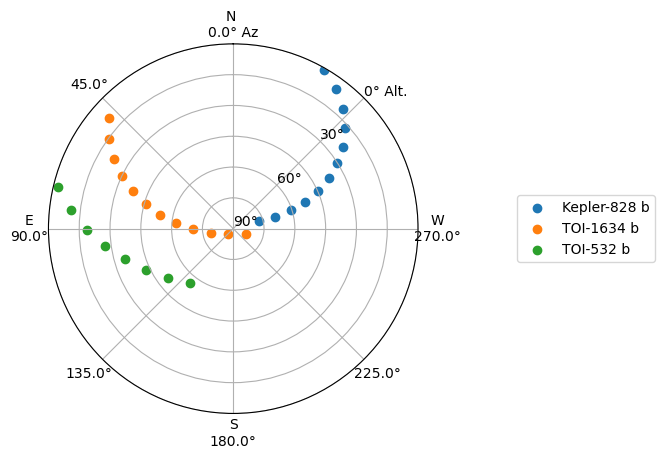

In [16]:

observing_time = Time('2023-11-11 02:00:00') # middle of observing window
observing_time += np.linspace(-4, 4, 12)*u.hour # plot forward and back 4 hours


plot_sky(Kepler_828b, villanova, observing_time)
plot_sky(TOI_1634b, villanova, observing_time)
plot_sky(TOI_532b, villanova, observing_time)
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5))

### Find Next n Eclipses

In [17]:
# Use NASA Exoplanet Archive for planet properties

planet_properties = NasaExoplanetArchive.query_object('Kepler-828 b', select='*', table='pscomppars')
# get relevant planet properties
epochkep = Time(planet_properties['pl_tranmid'], format='jd')
periodkep = planet_properties['pl_orbper']
tran_durkep = planet_properties['pl_trandur']


planet_properties = NasaExoplanetArchive.query_object('TOI-1634 b', select='*', table='pscomppars')
epoch1634 = Time(planet_properties['pl_tranmid'], format='jd')
period1634 = planet_properties['pl_orbper']
tran_dur1634 = planet_properties['pl_trandur']


planet_properties = NasaExoplanetArchive.query_object('TOI-532 b', select='*', table='pscomppars')
epoch532 = Time(planet_properties['pl_tranmid'], format='jd')
period532 = planet_properties['pl_orbper']
tran_dur532 = planet_properties['pl_trandur']


# Create an EclipsingSystem object
kepler828b = EclipsingSystem(primary_eclipse_time=epochkep, orbital_period=periodkep, duration=tran_durkep)

toi1634b = EclipsingSystem(primary_eclipse_time=epoch1634, orbital_period=period1634, duration=tran_dur1634)

toi532b = EclipsingSystem(primary_eclipse_time=epoch532, orbital_period=period532, duration=tran_dur532)


# Calculate next three mid-transit times which occur after ``obs_time``
obs_time = Time('2023-11-10 22:00:00')
n_eclipses = 3
print("The next", n_eclipses, "eclipses for Kepler-828 b occur on:", kepler828b.next_primary_eclipse_time(obs_time, n_eclipses))
print("The next", n_eclipses, "eclipses for TOI-1634 b occur on:", toi1634b.next_primary_eclipse_time(obs_time, n_eclipses))
print("The next", n_eclipses, "eclipses for TOI-532 b occur on:", toi532b.next_primary_eclipse_time(obs_time, n_eclipses))


UnitTypeError("MaskedQuantity instances require normal units, not <class 'astropy.units.function.logarithmic.DexUnit'> instances.") [astropy.table.table]
UnitTypeError("MaskedQuantity instances require normal units, not <class 'astropy.units.function.logarithmic.DexUnit'> instances.") [astropy.table.table]
UnitTypeError("MaskedQuantity instances require normal units, not <class 'astropy.units.function.logarithmic.DexUnit'> instances.") [astropy.table.table]
UnitTypeError("MaskedQuantity instances require normal units, not <class 'astropy.units.function.logarithmic.DexUnit'> instances.") [astropy.table.table]
UnitTypeError("MaskedQuantity instances require normal units, not <class 'astropy.units.function.logarithmic.DexUnit'> instances.") [astropy.table.table]
UnitTypeError("MaskedQuantity instances require normal units, not <class 'astropy.units.function.logarithmic.DexUnit'> instances.") [astropy.table.table]


The next 3 eclipses for Kepler-828 b occur on: ['2023-11-10 23:47:02.061' '2023-11-11 13:24:44.918'
 '2023-11-12 03:02:27.775']
The next 3 eclipses for TOI-1634 b occur on: ['2023-11-11 04:52:47.021' '2023-11-12 04:37:26.472'
 '2023-11-13 04:22:05.923']
The next 3 eclipses for TOI-532 b occur on: ['2023-11-11 06:30:35.326' '2023-11-13 14:20:57.955'
 '2023-11-15 22:11:20.584']


### Find When Objects are Observable

In [18]:

time_range = Time(["2023-11-10 22:00:00", "2023-11-11 06:00:00"])

constraints = [AltitudeConstraint(36*u.deg, 90*u.deg), AirmassConstraint(5), AtNightConstraint.twilight_civil()]


targets = [Kepler_828b, TOI_1634b, TOI_532b]


# Are targets *ever* observable in the time range? Duh of course they are that's why I picked them.
# This is dumb I don't want to print the results
ever_observable = is_observable(constraints, villanova, targets, time_range=time_range)

# Are targets *always* observable in the time range? No, of course not.
# Don't feel like printing the results - not important
always_observable = is_always_observable(constraints, villanova, targets, time_range=time_range)


def month(list):
    '''
    Converts month number to string month name. AKA me being OCD about this project.
    '''
    months = np.array([])
    x = ""
    
    for i in list:
        if i == {1}:
            x = "January"
        elif i == {2}:
            x = "February"
        elif i == {3}:
            x = "March"
        elif i == {4}:
            x = "April"
        elif i == {5}:
            x = "May"
        elif i == {6}:
            x = "June"
        elif i == {7}:
            x = "July"
        elif i == {8}:
            x = "August"
        elif i == {9}:
            x = "September"
        elif i == {10}:
            x = "October"
        elif i == {11}:
            x = "November"
        elif i == {12}:
            x = "December"
        else:
            x = "The object is not observable in any months."
        
        months = np.append(months, x)
    
    return months

# During what months are the targets best observable? I'll print this one because it's cool.
best_months = months_observable(constraints, villanova, targets, time_range)

print("Kepler-828 b is best observed in", month(best_months)[0])
print("TOI-1634 b is best observed in", month(best_months)[1])
print("TOI-532 b is best observed in", month(best_months)[2])

Kepler-828 b is best observed in November
TOI-1634 b is best observed in November
TOI-532 b is best observed in November


### Observability Plot

Only showing one plot (Kepler-828 b) for space purposes. 

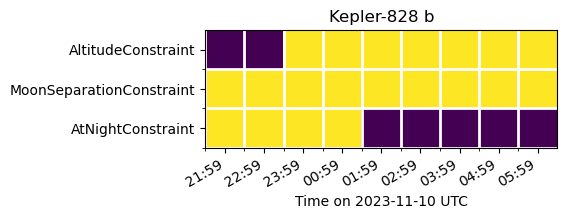

In [23]:

constraints = [AtNightConstraint.twilight_astronomical(),
               MoonSeparationConstraint(min=45 * u.deg),
               AltitudeConstraint(min=36 * u.deg)]

# Define range of times to observe between
start_time = Time('2023-11-10 22:00:00')
end_time = Time('2023-11-11 06:00:00')
time_resolution = 1 * u.hour

# Create grid of times from ``start_time`` to ``end_time``
# with resolution ``time_resolution``
time_grid = time_grid_from_range([start_time, end_time],
                                 time_resolution=time_resolution)

observability_grid = np.zeros((len(constraints), len(time_grid)))

for i, constraint in enumerate(constraints):
    # Evaluate each constraint
    observability_grid[i, :] = constraint(villanova, Kepler_828b, times=time_grid)

# Create plot showing observability of the target:

extent = [-0.5, -0.5+len(time_grid), -0.5, 2.5]

fig, ax = plt.subplots()
ax.imshow(observability_grid, extent=extent)

ax.set_yticks(range(0, 3))
ax.set_yticklabels([c.__class__.__name__ for c in constraints])

ax.set_xticks(range(len(time_grid)))
ax.set_xticklabels([t.datetime.strftime("%H:%M") for t in time_grid])

ax.set_xticks(np.arange(extent[0], extent[1]), minor=True)
ax.set_yticks(np.arange(extent[2], extent[3]), minor=True)

ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
ax.tick_params(axis='x', which='minor', bottom='off')
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

ax.tick_params(axis='y', which='minor', left='off')
ax.set_xlabel('Time on {0} UTC'.format(time_grid[0].datetime.date()))
ax.set_title("Kepler-828 b")
fig.subplots_adjust(left=0.35, right=0.9, top=0.9, bottom=0.1)
plt.show()

### Schedule Observations

In [20]:

# Define the read-out time, exposure duration and number of exposures
read_out = 20 * u.second
kepler_exp = 100*u.second
toi1634_exp = 100*u.second
toi532_exp = 100*u.second
n = 16
blocks = []

half_night_start = Time('2023-11-10 22:00:00')
half_night_end = Time('2023-11-11 06:00:00')
first_half_night = TimeConstraint(half_night_start, half_night_end)
# Create ObservingBlocks for each filter and target with our time
# constraint, and durations determined by the exposures needed
for priority, bandpass in enumerate(['B', 'G', 'R']):
    # We want each filter to have separate priority (so that target
    # and reference are both scheduled)
    b = ObservingBlock.from_exposures(Kepler_828b, priority, kepler_exp, n, read_out,
                                        configuration = {'filter': bandpass},
                                        constraints = [first_half_night])
    blocks.append(b)
    b = ObservingBlock.from_exposures(TOI_1634b, priority, toi1634_exp, n, read_out,
                                        configuration = {'filter': bandpass},
                                        constraints = [first_half_night])
    
    blocks.append(b)
    b = ObservingBlock.from_exposures(TOI_532b, priority, toi532_exp, n, read_out,
                                        configuration = {'filter': bandpass},
                                        constraints = [first_half_night])
    blocks.append(b)

# Initialize a transitioner object with the slew rate and/or the duration of other transitions (e.g. filter changes)
slew_rate = 4*u.deg/u.second
transitioner = Transitioner(slew_rate,
                            {'filter':{('B','G'): 10*u.second,
                                       ('G','R'): 10*u.second,
                                       'default': 30*u.second}})

global_constraints = [AirmassConstraint(max = 3, boolean_constraint = False), AtNightConstraint.twilight_civil()]

noon_before = Time('2023-11-10 16:00:00')
noon_after = Time('2023-11-11 16:00:00')


# Initialize the sequential scheduler with the constraints and transitioner
prior_scheduler = PriorityScheduler(constraints = global_constraints,
                                    observer = villanova,
                                    transitioner = transitioner)
# Initialize a Schedule object, to contain the new schedule
priority_schedule = Schedule(noon_before, noon_after)

# Call the schedule with the observing blocks and schedule to schedule the blocks
print(prior_scheduler(blocks, priority_schedule))

priority_schedule.to_table()


Schedule containing 9 observing blocks between 2023-11-10 16:00:00.000 and 2023-11-11 16:00:00.000


target,start time (UTC),end time (UTC),duration (minutes),ra,dec,configuration
str15,str23,str23,float64,str32,str32,object
Kepler-828 b,2023-11-10 22:18:20.014,2023-11-10 22:50:20.014,32.00000000000004,286.8872631865875,42.47124159281917,{'filter': 'B'}
TransitionBlock,2023-11-10 22:50:20.014,2023-11-10 22:50:40.014,0.33333333333327886,,,['filter:B to G']
Kepler-828 b,2023-11-10 22:50:40.014,2023-11-10 23:22:40.014,31.999999999999886,286.8872631865875,42.47124159281917,{'filter': 'G'}
TransitionBlock,2023-11-10 23:22:40.014,2023-11-10 23:23:00.014,0.33333333333327886,,,['filter:G to R']
Kepler-828 b,2023-11-10 23:23:00.014,2023-11-10 23:55:00.014,31.999999999999886,286.8872631865875,42.47124159281917,{'filter': 'R'}
TransitionBlock,2023-11-10 23:55:00.014,2023-11-10 23:55:40.014,0.6666666666665577,,,[]
TOI-532 b,2023-11-11 02:28:20.023,2023-11-11 03:00:20.023,32.00000000000004,85.07995159,11.5628011,{'filter': 'R'}
TransitionBlock,2023-11-11 03:00:20.023,2023-11-11 03:00:40.023,0.33333333333343873,,,[]
TOI-1634 b,2023-11-11 03:01:00.024,2023-11-11 03:33:00.024,32.00000000000004,56.39016879,37.11222224,{'filter': 'R'}


### Scheduling Blocks on Airmass Plot

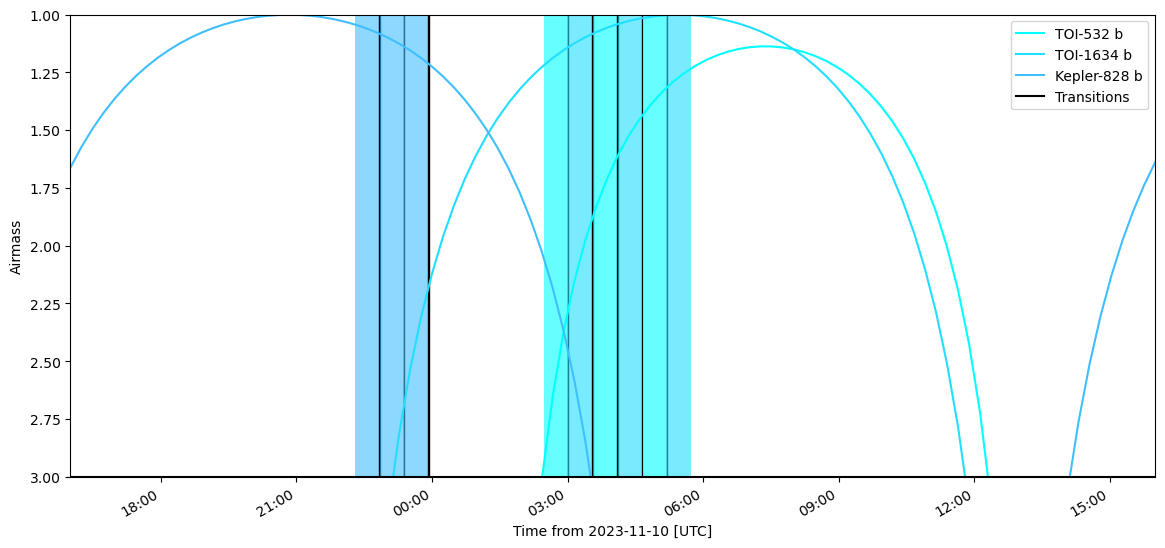

In [21]:
from astroplan.plots import plot_schedule_airmass

# plot the schedule with the airmass of the targets
plt.figure(figsize = (14,6))
plot_schedule_airmass(priority_schedule)
plt.legend(loc = "upper right")
plt.show()

### Same Plot with More Observation Blocks

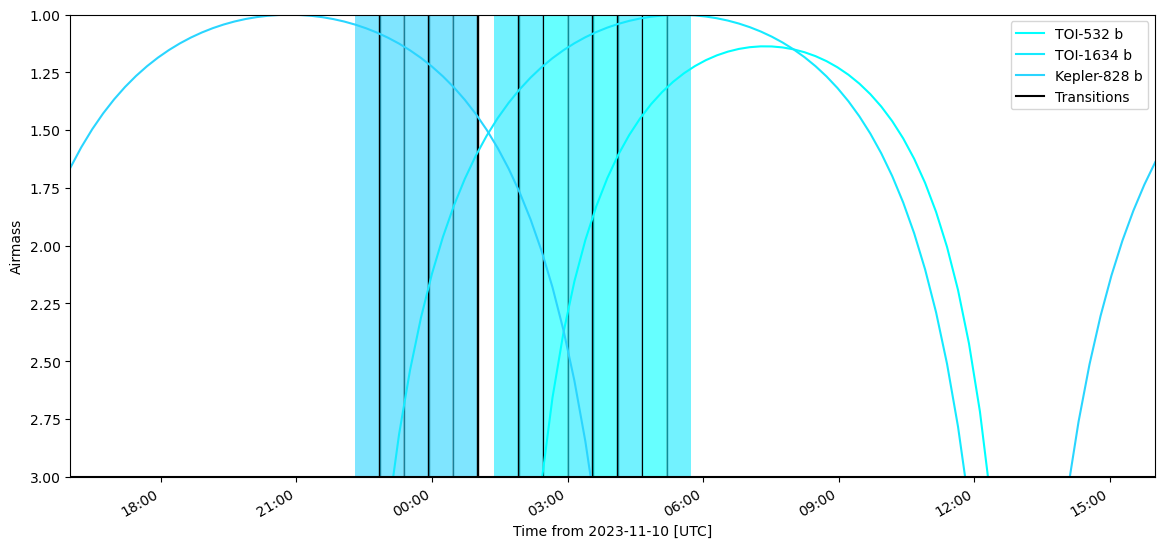

In [22]:
prior_scheduler(blocks, priority_schedule)
plt.figure(figsize = (14,6))
plot_schedule_airmass(priority_schedule)
plt.legend(loc = "upper right")
plt.show()